### Functions and Classes

In [ ]:
# custom infoGAN with q in training loop
# References:
# https://machinelearningmastery.com/how-to-develop-an-information-maximizing-generative-adversarial-network-infogan-in-keras/
# https://towardsdatascience.com/build-infogan-from-scratch-f20ee85cba03


class infoGAN(GAN):
    def __init__(
        self,
        discriminator,
        generator,
        q,
        latent_dim,
        categorical_control=None,
        continuous_control=None,
    ):
        """
        categorical_control :: list of number of classes in one-hot vector
        continous_control :: list of tuple corrseponding to
                            ranges of uniform distribution for code, i.e. (-1, 1)

        !! continuous codes yet to be implemented !!
        """
        super(infoGAN, self).__init__(discriminator, generator, latent_dim)

        self.q = q
        self.categorical_control = categorical_control or []
        self.continuous_control = continuous_control or []

    def compile(
        self,
        d_optimizer,
        g_optimizer,
        d_loss_fn,
        g_loss_fn,
        q_loss_fn,
        metrics=["accuracy"],
    ):
        super(GAN, self).compile()
        self.discriminator.compile(
            optimizer=d_optimizer, loss=d_loss_fn, metrics=metrics
        )
        self.generator.compile(optimizer=g_optimizer, loss=g_loss_fn)
        self.q.compile(optimizer=d_optimizer, loss=q_loss_fn)

    def _varied_continuous_codes(self, no_of_samples):
        raise NotImplementedError
        # return tf.random.uniform(shape=(no_of_samples,), minval=self.continuous_control[0], maxval=self.continuous_control[1])

    def _varied_categorical_codes(self, no_of_samples, code_size):
        return tf.one_hot(indices=tf.range(no_of_samples), depth=code_size)

    def _random_categorical_codes(self, no_of_samples, code_size):
        random_indices = tf.random.uniform(
            shape=(no_of_samples,), minval=0, maxval=code_size, dtype=tf.int32
        )
        return tf.one_hot(indices=random_indices, depth=code_size)

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        batch_size = tf.shape(real_images)[0]

        #==================================
        # Train discriminator on real
        #==================================
        real_images = real_images / 255
        real_labels = tf.fill((batch_size, 1), 0.9)
        with tf.GradientTape() as tape:
            real_predictions = self.discriminator(real_images)
            d_real_loss = self.discriminator.compiled_loss(
                real_labels,
                real_predictions,
            )
        d_real_grads = tape.gradient(d_real_loss, self.discriminator.trainable_weights)
        self.discriminator.optimizer.apply_gradients(
            zip(d_real_grads, self.discriminator.trainable_weights)
        )

        #==================================
        # Train discriminator and q on fake
        #==================================
        inputs = []
        latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        inputs.append(latent_vectors)

        if len(self.categorical_control) != 0:
            cat_codes = [
                self._random_categorical_codes(batch_size, code_size)
                for code_size in self.categorical_control
            ]
            inputs.extend(cat_codes)

        if len(self.continuous_control) != 0:
            # cont_codes = tf.random.uniform(
            #     shape=(batch_size,),
            #     minval=self.continuous_control[0],
            #     maxval=self.continuous_control[1],
            # )
            # inputs.append(self.cont_codes)
            raise NotImplementedError

        fake_images = self.generator(inputs)
        fake_labels = tf.fill((batch_size, 1), 0.1)
        with tf.GradientTape() as d_tape, tf.GradientTape() as q_tape:
            fake_predictions = self.discriminator(fake_images)
            fake_information = self.q(fake_images)

            d_fake_loss = self.discriminator.compiled_loss(
                fake_labels, fake_predictions
            )
            q_fake_loss = self.q.compiled_loss(cat_codes, fake_information)
        d_fake_grads = d_tape.gradient(
            d_fake_loss, self.discriminator.trainable_weights
        )
        self.discriminator.optimizer.apply_gradients(
            zip(d_fake_grads, self.discriminator.trainable_weights)
        )
        q_fake_grads = q_tape.gradient(q_fake_loss, self.q.trainable_weights)
        self.q.optimizer.apply_gradients(zip(q_fake_grads, self.q.trainable_weights))

        #==================================
        # Train the generator
        #==================================
        inputs = []
        inputs.append(tf.random.normal(shape=(2 * batch_size, self.latent_dim)))
        if len(self.categorical_control) != 0:
            cat_codes = [
                self._random_categorical_codes(2 * batch_size, code_size)
                for code_size in self.categorical_control
            ]
            inputs.extend(cat_codes)

        misleading_labels = tf.ones((2 * batch_size, 1))
        with tf.GradientTape() as tape:
            misleading_predictions = self.discriminator(self.generator(inputs))
            misleading_information = self.q(self.generator(inputs))
            g_d_loss = self.generator.compiled_loss(
                misleading_labels, misleading_predictions
            )
            g_q_loss = self.q.compiled_loss(cat_codes, misleading_information)
            g_loss = g_d_loss + g_q_loss
        g_grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.generator.optimizer.apply_gradients(
            zip(g_grads, self.generator.trainable_weights)
        )

        log_metrics = {"d_loss": d_real_loss + d_fake_loss, "g_loss": g_loss}
        return log_metrics

In [ ]:
# plot images with varied codes and constant noise
class infoGANImageLogger(GeneratorImageLogger):
    def __init__(self, latent_dim, log_freq=5, subplot_rows=5, logdir=None):
        super(infoGANImageLogger, self).__init__(
            latent_dim, log_freq, subplot_rows, logdir
        )

    def latent_categorical_pairs(self, latent, code_size):
        cat_code = self.model._varied_categorical_codes(code_size, code_size)
        multiples = [len(latent), 1]
        codes = tf.tile(cat_code, multiples=multiples)

        repeats = tf.fill((len(latent)), code_size)
        noise = tf.repeat(latent, repeats=repeats, axis=0)

        if len(self.model.continuous_control) != 0:
            raise NotImplementedError
            inputs.append(
                tf.fill((self.subplot_rows), self.model._generate_continuous_codes(1))
            )

        return noise, codes

    def evalute_continuous_control(self, latent):
        # cont_codes = self._generate_continuous_codes(self.categorical_control)
        # repeats = tf.fill((len(latent)), len(cont_codes))
        # multiples = [len(latent), 1]

        # inputs = [tf.repeat(latent, repeats=repeats, axis=0)]

        # if self.continuous_control:
        #     inputs.append(tf.fill((self.subplot_rows), self._generate_categorical_codes(1)))

        # inputs.append(tf.tile(cont_codes, multiples=multiples))

        # return self.model.generator(inputs)
        raise NotImplementedError

    def on_train_begin(self, logs=None):
        if self.logdir is not None:
            if len(self.model.categorical_control):
                for i in range(len(self.model.categorical_control)):
                    os.makedirs(f"{self.logdir}/categorical_{i}", exist_ok=True)

            if len(self.model.continuous_control):
                os.makedirs(f"{self.logdir}/continuous", exist_ok=True)

    # def _generate_varied_categoricals(self)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.log_freq != 0:
            return

        latent = tf.random.normal(shape=(self.subplot_rows, self.latent_dim))

        if len(self.model.categorical_control) != 0:
            # for each code
            for i, code_size in enumerate(self.model.categorical_control):
                one_hots = [  # generate list of constant onehot for all codes
                    tf.repeat(
                        tf.one_hot(
                            indices=[0],
                            depth=control,
                        ),
                        repeats=code_size * self.subplot_rows,
                        axis=0,
                    )
                    for control in self.model.categorical_control
                ]
                
                noise, codes = self.latent_categorical_pairs(latent, code_size)
                one_hots[i] = codes
                inputs = [noise, *one_hots]
                cat_fig = self._generate_img_subplot(self.model.generator(inputs))

                wandb.log({f"categorical_{i}": cat_fig}, step=epoch)
                if self.logdir is not None:
                    plt.savefig(f"{self.logdir}/categorical_{i}/epoch_{epoch}")
                plt.close(cat_fig)

        if len(self.model.continuous_control) != 0:
            # generated_continuous = self.evalute_continuous_control(latent)
            # cont_fig = self._generate_img_subplot(generated_continuous)

            # wandb.log({"continuous_code": cont_fig}, step=epoch)
            # if self.logdir is not None:
            #     plt.savefig(f"{self.logdir}/continuous/epoch_{epoch}")
            # plt.close(cont_fig)
            raise NotImplementedError

In [ ]:
class infoGANFIDLogger(FIDLogger):
    def __init__(self, latent_dim, log_freq=5):
        super(infoGANFIDLogger, self).__init__(latent_dim, log_freq)

    def _generate_inputs(self):
        latent_vectors = tf.random.normal(
            shape=(len(self.real_embeddings), self.latent_dim)
        )
        dataset_dict = {
            "noise": tf.data.Dataset.from_tensor_slices(latent_vectors).batch(100)
        }
        
        for i, code_size in enumerate(self.model.categorical_control):
            code_vector = self.model._random_categorical_codes(
                len(self.real_embeddings), code_size
            )

            dataset_dict[f"cat_control_{i}"] = tf.data.Dataset.from_tensor_slices(
                code_vector
            ).batch(100)

        input_dataset = tf.data.Dataset.zip(dataset_dict)

        return input_dataset

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.log_freq != 0:
            logs["fid"] = np.nan
            return

        input_dataset = self._generate_inputs()

        gen_images = []
        for batch in input_dataset:
            gen_images.extend(self.model.generator(batch.values()) * 255)
        gen_embeddings = self.compute_embeddings(self.resize_images(gen_images))

        fid = self.calculate_frechet_distance(self.real_embeddings, gen_embeddings)

        logs["fid"] = fid
        wandb.log({"FID": fid}, step=epoch)
        return logs

### Setup

In [ ]:
EPOCHS_TRAINED = 0
group = "infoGAN"

In [ ]:
model_name = "strong_q_infogan"

In [ ]:
from datetime import datetime
now = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

In [ ]:
wandb.init(
    project="cifar10_gan",
    name=f"{model_name}_{now}",
    config=dict(
        architecture="infogan",
        latent_dim=128,
        disc_layers=["3x3x64", "3x3x64_1", "3x3x128", "3x3x128_1", "FC100"],
        gen_layers=["FC4*4*72","3x3x128", "3x3x64", "3x3x64_1", "3x3x32"],
        control={"categorical": [10], "continuous":None},
    ),
    group=group,
)
# key 1b33553de266344186f717f703fad4a31800e0b3

### Architecture

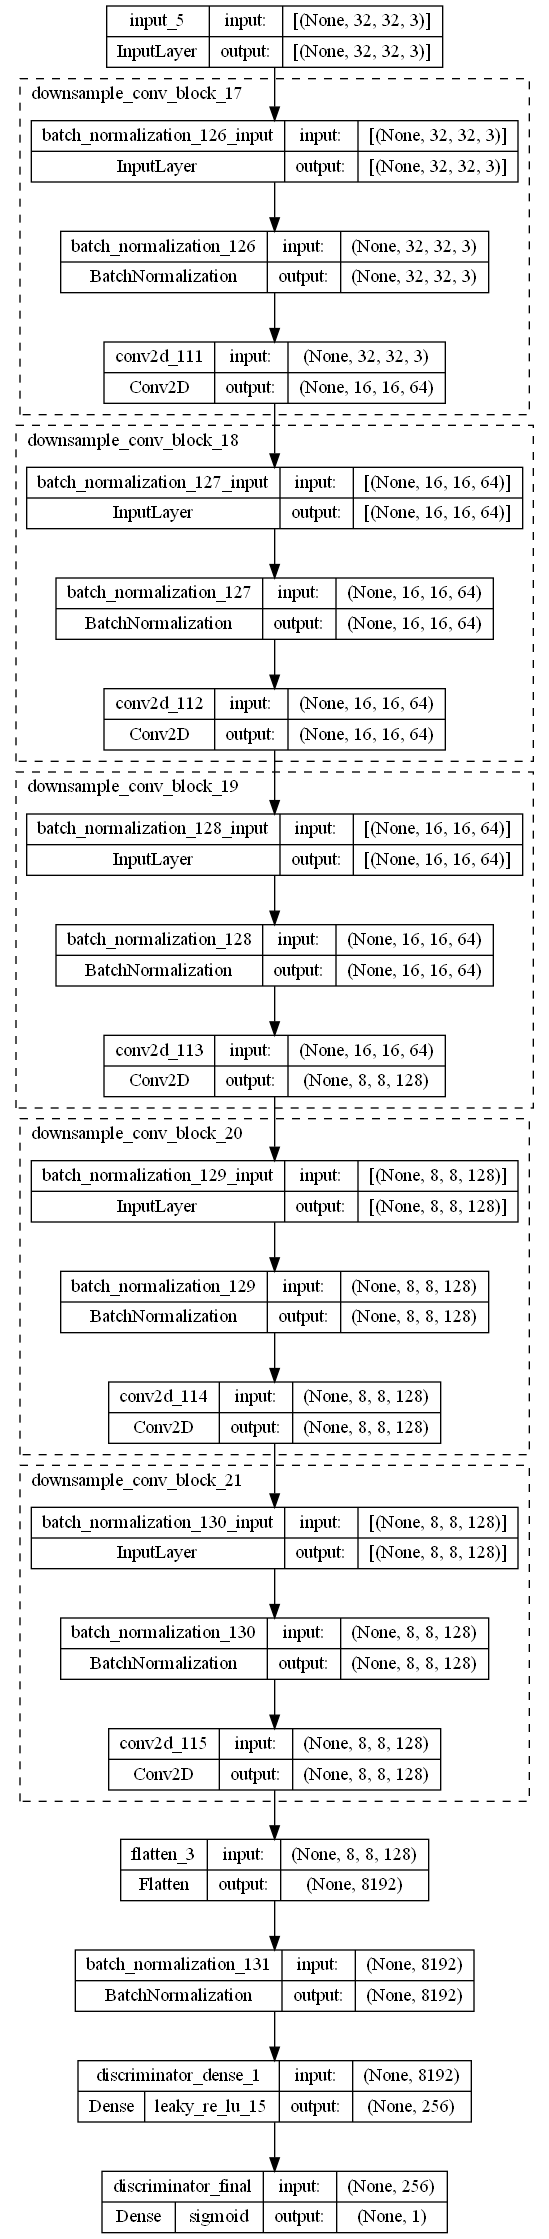

In [ ]:
d_in = (keras.Input(shape=(32, 32, 3)))

d_conv = conv_block(64, use_bn=True)(d_in)
d_conv = conv_block(64, stride=1, use_bn=True)(d_conv)
d_conv = conv_block(128, use_bn=True)(d_conv)
d_conv = conv_block(128, stride=1, use_bn=True)(d_conv)
d_conv = conv_block(128, stride=1, use_bn=True)(d_conv)
d_flat = keras.layers.Flatten()(d_conv)

d_dense = keras.layers.BatchNormalization()(d_flat)
d_dense = (
    keras.layers.Dense(
        256, activation=keras.layers.LeakyReLU(alpha=0.1), name="discriminator_dense_1"
    )
)(d_dense)

d_out = keras.layers.Dense(1, activation="sigmoid", name="discriminator_final")(d_dense)

discriminator = keras.Model(inputs=d_in, outputs=d_out, name="discriminator")
plot_model(discriminator, show_shapes=True, show_layer_activations=True, expand_nested=True)

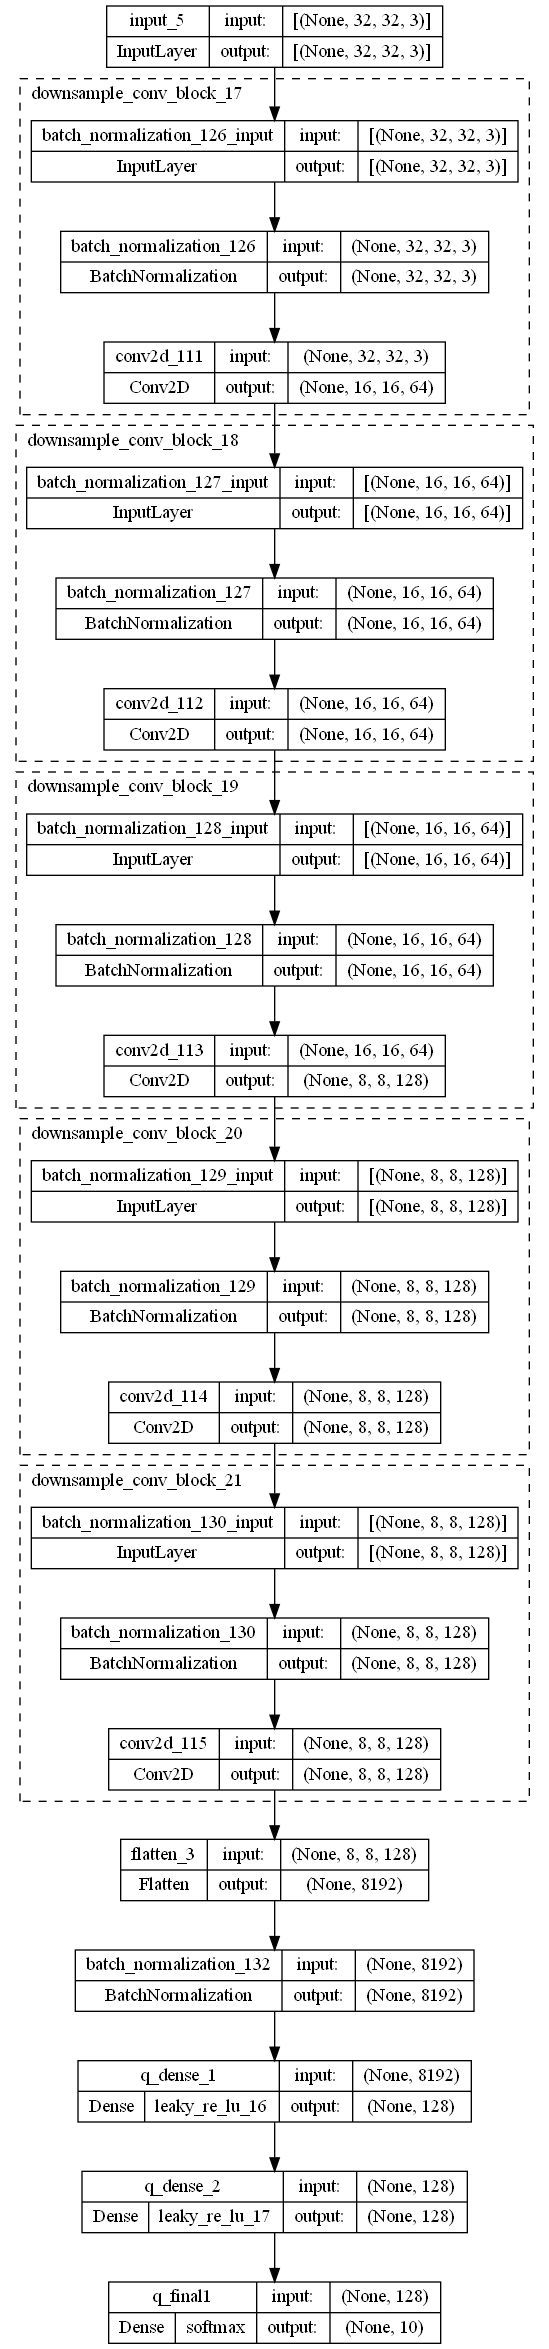

In [ ]:
q_out = keras.layers.BatchNormalization()(d_flat)
q_out = keras.layers.Dense(128, activation=keras.layers.LeakyReLU(alpha=0.1), name="q_dense_1")(q_out)
q_out = keras.layers.Dense(128, activation=keras.layers.LeakyReLU(alpha=0.1), name="q_dense_2")(q_out)
q_cat1 = keras.layers.Dense(10, activation="softmax", name="q_final1")(q_out)

q = keras.Model(inputs=d_in, outputs=[q_cat1], name="q")
plot_model(q, show_shapes=True, show_layer_activations=True, expand_nested=True)

In [ ]:
q.summary(expand_nested=True)

# 1.49 mil params

Model: "q"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 downsample_conv_block_17 (S  (None, 16, 16, 64)       1804      
 equential)                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| batch_normalization_126 (Ba  (None, 32, 32, 3)      12        |
| tchNormalization)                                             |
|                                                               |
| conv2d_111 (Conv2D)       (None, 16, 16, 64)        1792      |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 downsample_conv_block_18 (S  (None, 16, 16, 64)       37184     
 equential)                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|

In [ ]:
discriminator.summary(expand_nested=True)

# 2.3mil params

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 downsample_conv_block_17 (S  (None, 16, 16, 64)       1804      
 equential)                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| batch_normalization_126 (Ba  (None, 32, 32, 3)      12        |
| tchNormalization)                                             |
|                                                               |
| conv2d_111 (Conv2D)       (None, 16, 16, 64)        1792      |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 downsample_conv_block_18 (S  (None, 16, 16, 64)       37184     
 equential)                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

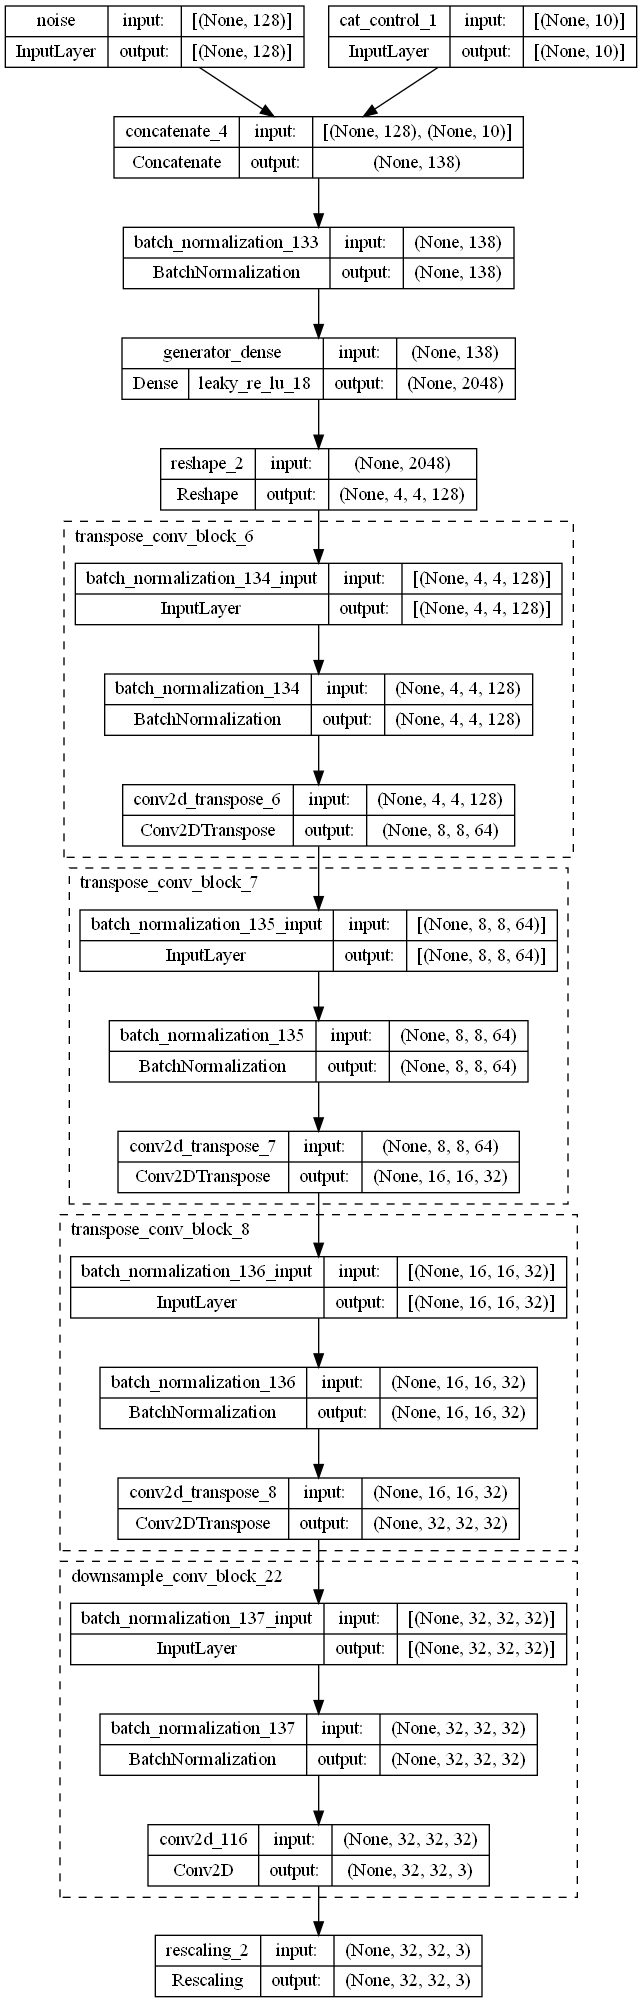

In [ ]:
g_noise = keras.Input(shape=(128,), name="noise")
g_code1 = keras.Input(shape=(10,), name="cat_control_1")

concat_layer = keras.layers.Concatenate(axis=-1)([g_noise, g_code1])

g_dense = keras.layers.BatchNormalization()(concat_layer)
g_dense = (
    keras.layers.Dense(
        4 * 4 * 128,
        activation=keras.layers.LeakyReLU(alpha=0.1),
        name="generator_dense",
    )
)(g_dense)
g_conv = keras.layers.Reshape((4, 4, 128))(g_dense)

g_conv = conv_transpose_block(64, use_bn=True)(g_conv)
g_conv = conv_transpose_block(32, use_bn=True)(g_conv)
g_conv = conv_transpose_block(32, use_bn=True)(g_conv)
g_conv = conv_block(3, stride=1, activation="tanh", use_bn=True)(g_conv)

#output range 0 to 1
g_out = keras.layers.Rescaling(scale=0.5, offset=0.5)(g_conv)

generator = keras.Model(inputs=[g_noise, g_code1], outputs=g_out, name="generator")

plot_model(generator, show_shapes=True, show_layer_activations=True, expand_nested=True)

In [ ]:
generator.summary(expand_nested=True)

# 388k params

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 cat_control_1 (InputLayer)     [(None, 10)]         0           []                               
                                                                                                  
 concatenate_4 (Concatenate)    (None, 138)          0           ['noise[0][0]',                  
                                                                  'cat_control_1[0][0]']          
                                                                                                  
 batch_normalization_133 (Batch  (None, 138)         552         ['concatenate_4[0][0]']  

1/1 [==============================] - 0s 161ms/step
Discriminator score: [0.4950121]


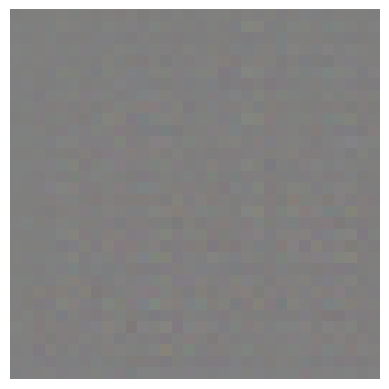

In [ ]:
infogan = infoGAN(
    discriminator=discriminator,
    generator=generator,
    q=q,
    latent_dim=wandb.config.latent_dim,
    categorical_control=wandb.config.control["categorical"],
    continuous_control=wandb.config.control["continuous"],
)
infogan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=2 * 10**-4),
    g_optimizer=keras.optimizers.Adam(learning_rate=1 * 10**-3),
    d_loss_fn=keras.losses.BinaryCrossentropy(),
    g_loss_fn=keras.losses.BinaryCrossentropy(),
    q_loss_fn=keras.losses.CategoricalCrossentropy(),
)

# infogan.load_weights("./chkpts/050-1825.47")


random_vector = tf.random.normal(shape=(1, wandb.config.latent_dim))
random_onehot1 = tf.one_hot(
    tf.random.uniform(shape=(1,), minval=0, maxval=10, dtype=tf.int32), 10
)
generated_image = infogan.generator.predict(
    [random_vector, random_onehot1]
)
discriminator_score = infogan.discriminator.predict(generated_image)
print("Discriminator score:", discriminator_score[0])
plt.imshow(generated_image[0])
plt.grid(False)
plt.axis(False)
plt.show()

### Training

In [ ]:
BATCH_SIZE = 100
EPOCHS = 10

In [ ]:
history = infogan.fit(
    sharpened_images,
    epochs=EPOCHS_TRAINED + EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        infoGANImageLogger(
            logdir=f"images/{model_name}/",
            latent_dim=wandb.config.latent_dim,
            log_freq=5,
            subplot_rows=15
        ),
        infoGANFIDLogger(latent_dim=wandb.config.latent_dim, log_freq=5),
        WandbMetricsLogger(),
        WandbEpochModelCheckpoint(
            filepath=f"chkpts/{model_name}/" + "{epoch:03d}-{fid:.1f}",
            frequency=5,
            save_weights_only=True,
        ),
        keras.callbacks.CSVLogger(
            f"histories/{model_name}.csv", append=bool(EPOCHS_TRAINED)
        ),
    ],
    initial_epoch=EPOCHS_TRAINED,
)

history_df = pd.read_csv(f"histories/{model_name}.csv")

EPOCHS_TRAINED = len(history_df)
EPOCHS_TRAINED

Epoch 41/60
600/600 [==============================] - 75s 125ms/step - d_loss: 0.7686 - g_loss: 2.1950 - fid: nan
Epoch 42/60
600/600 [==============================] - 75s 126ms/step - d_loss: 0.7631 - g_loss: 2.1864 - fid: nan
Epoch 43/60
600/600 [==============================] - 75s 126ms/step - d_loss: 0.7651 - g_loss: 2.1823 - fid: nan
Epoch 44/60
600/600 [==============================] - 75s 126ms/step - d_loss: 0.7584 - g_loss: 2.2026 - fid: nan
Epoch 45/60
600/600 [==============================] - 92s 153ms/step - d_loss: 0.7605 - g_loss: 2.1969 - fid: 1257.4450
Epoch 46/60
600/600 [==============================] - 76s 127ms/step - d_loss: 0.7592 - g_loss: 2.1957 - fid: nan
Epoch 47/60
600/600 [==============================] - 76s 127ms/step - d_loss: 0.7533 - g_loss: 2.2002 - fid: nan
Epoch 48/60
600/600 [==============================] - 76s 127ms/step - d_loss: 0.7539 - g_loss: 2.2051 - fid: nan
Epoch 49/60
600/600 [==============================] - 76s 127ms/step - d_

60

In [ ]:
wandb.finish()

FID,█▄▁▁▁▁▂▂▂▂▂▂
epoch/d_loss,▄▃▁▃▁▃▁▁▂▂█▂▂▃▃▅▆▆▃▅▄▆▅▃▆█▂▂▅▄▃▂▁▃▂▂▃▁▁▃
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/fid,█ ▄ ▁ ▁ ▂ ▂ ▂ ▂ ▂
epoch/g_loss,█▇▃▂▂▁▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▂▁▂▁▂▂▁▂
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
FID,1269.67455
epoch/d_loss,0.75434
epoch/epoch,59
epoch/fid,1269.67455
epoch/g_loss,2.34355


### Evaluation

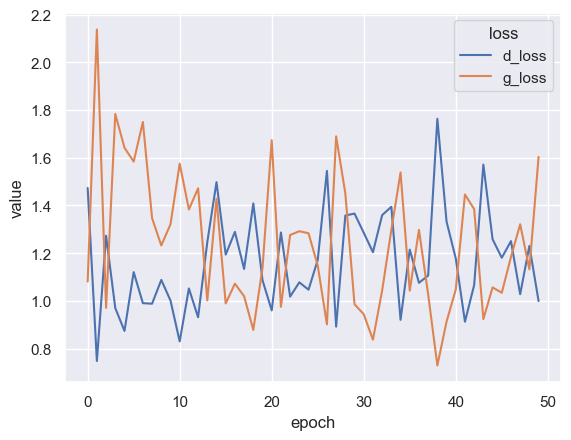

In [ ]:
history_df = pd.read_csv(f"histories/{model_name}.csv")

sns.lineplot(
    data=pd.melt(
        history_df, id_vars="epoch", value_vars=["d_loss", "g_loss"], var_name="loss"
    ),
    y="value",
    x="epoch",
    hue="loss",
)

plt.show()

In [ ]:
wandb.login()
api = wandb.Api()
run_url = "bevanpoh/cifar10_gan"
runGroup = api.runs(
    run_url, filters={"group": group, "display_name": {"$regex": f"{model_name}_.+"}}
)

# hover over images and click top right to view images in fullscreen
for run in runGroup:
    run.display(height=760)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bevanpoh. Use `wandb login --relogin` to force relogin
c:\Users\p2112745\.conda\envs\gpu_env\lib\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
